# Respiration

## Setup

First step is to install Laura's package for analysing respiration data (⚠️ under development - please feel free to let me know if you discover any errors). First draft of documentation can be found [here](laurabpaulsen.github.io/pyriodic/). We are also installing a package for bayesian estimation of the psychometric function and statsmodels which will be used at the end of this notebook!


In [1]:
!pip install git+https://github.com/laurabpaulsen/pyriodic.git
!pip install psignifit
!pip install statsmodels

  Cloning https://github.com/laurabpaulsen/pyriodic.git to /tmp/pip-req-build-9kyjb60g
  Running command git clone --filter=blob:none --quiet https://github.com/laurabpaulsen/pyriodic.git /tmp/pip-req-build-9kyjb60g
  Resolved https://github.com/laurabpaulsen/pyriodic.git to commit 39dd430ba5b436e35365bd8822012b7162e202de
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from pathlib import Path
import mne
import pandas as pd
import numpy as np

In [3]:
MEG_path = Path("/work/MEG_data/workshop_data")
subject = "0165"
session_folder = "20250923_000000"
raw_path = MEG_path / subject / session_folder / "workshop_2025_raw.fif"
behav_path = list((MEG_path / "behavioural_logs").glob(f"{subject}*"))[0]

In [4]:
raw = mne.io.read_raw_fif(raw_path)

# we will only look at respiration today, so we are only keeping channel with respiration data and the stimulus channel
raw.pick(["MISC001", "STI101"])
raw.load_data()

Opening raw data file /work/MEG_data/workshop_data/0165/20250923_000000/workshop_2025_raw.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 153000 ... 1749999 =    153.000 ...  1749.999 secs
Ready.
Opening raw data file /work/MEG_data/workshop_data/0165/20250923_000000/workshop_2025_raw-1.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x

<Raw | workshop_2025_raw.fif, 2 x 1598000 (1598.0 s), ~29.3 MiB, data loaded>

# preparing the events
And getting correct and incorrect from logfile

        self.triggers = dict()
        self.triggers['stimulus_0']           =  1
        self.triggers['stimulus_1']           =  3
        self.triggers['mask']                 =  4
        self.triggers['response_stimulus_0']  =  6
        self.triggers['response_stimulus_1']  =  8
        self.triggers['response_PAS_1']       = 10
        self.triggers['response_PAS_2']       = 12
        self.triggers['response_PAS_3']       = 14
        self.triggers['response_PAS_4']       = 16
        self.triggers['response_auto']        = 32
        self.triggers['response_PAS_auto']    = 64

In [5]:
# Load the logfile
df = pd.read_csv(behav_path, index_col=False)

events = mne.find_events(raw, shortest_event=1)

# Only keep events with trigger values in event_ids
event_ids_exp = {
    "stim/0": 1, 
    "stim/1": 3
}

valid_event_values = set(event_ids_exp.values())
events = events[np.isin(events[:, 2], list(valid_event_values))]

df["correct"] = (df["target_type"] == df["objective_response"]).astype(int)


Finding events on: STI101
1600 events found on stim channel STI101
Event IDs: [ 1  3  4  6  8 10 12 14 16]


## Created a updated event array that reflects whether the participant responded correctly

In [ ]:

event_ids= {
    "/correct": 1,
    "incorrect": 0
}

new_events=[]

for event, correct in zip(events, df["correct"]):
    new_events.append([event[0], event[1], correct])

new_events = np.array(new_events)
print("First 5 updated events:\n", new_events[:5])

First 5 updated events:
 [[215888      0      1]
 [221744      0      0]
 [227505      0      1]
 [233351      0      1]
 [239279      0      1]]


# Preprocessing of the respiratory signal

In [7]:
from pyriodic.preproc import RawSignal
from pyriodic.viz import plot_phase_diagnostics, CircPlot
from pyriodic.phase_events import create_phase_events
from pyriodic import Circular


import matplotlib.pyplot as plt
%matplotlib inline


<Axes: xlabel='Time (s)', ylabel='Amplitude'>

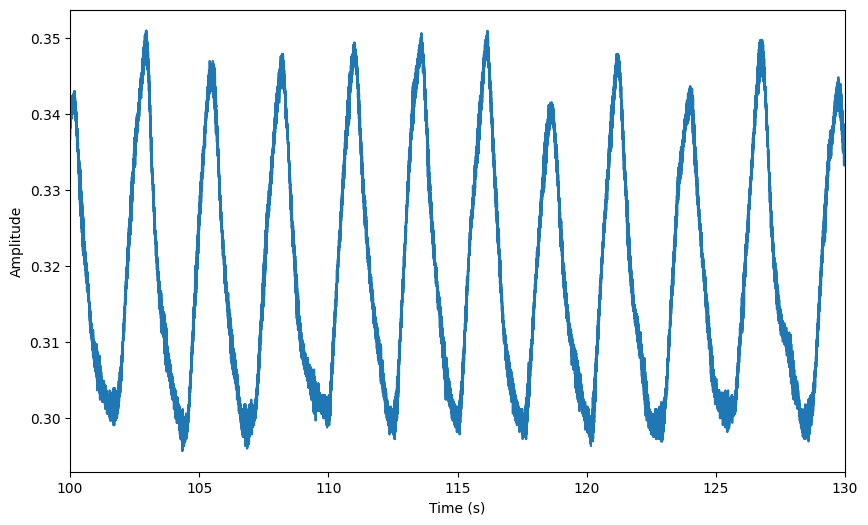

In [8]:
# extract data from the mne Raw object
resp_ts = raw.get_data()[0].squeeze()

# Create a pyriodic object with the respiration data
resp_raw = RawSignal(resp_ts, fs=raw.info["sfreq"])
resp_raw.plot(start=100, duration=30)

# Filtering
As with MEG data, we can bandpass filter the respiration signal between 0.1 and 1 Hz (≈6–60 breaths per minute) to retain normal breathing rhythms while removing slow drifts and high-frequency noise.

<Axes: xlabel='Time (s)', ylabel='Amplitude'>

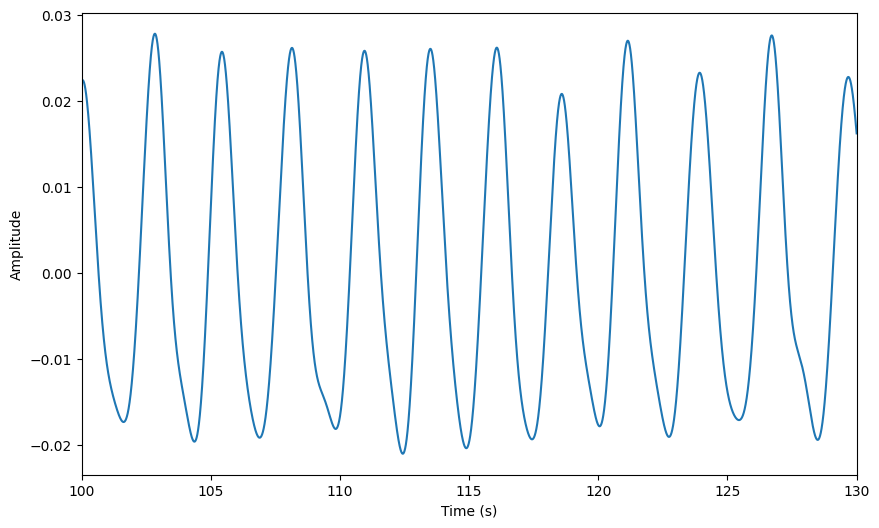

In [9]:
resp_raw.filter_bandpass(low=0.1, high=1)
resp_raw.plot(start=100, duration=30)

# Extracting phase angles

In [10]:
phase, peaks, troughs = resp_raw.phase_twopoint(
    prominence=0.01,  # play around with these parameters if the peak detection seems to fail in the following plot!
    distance=0.5
    )

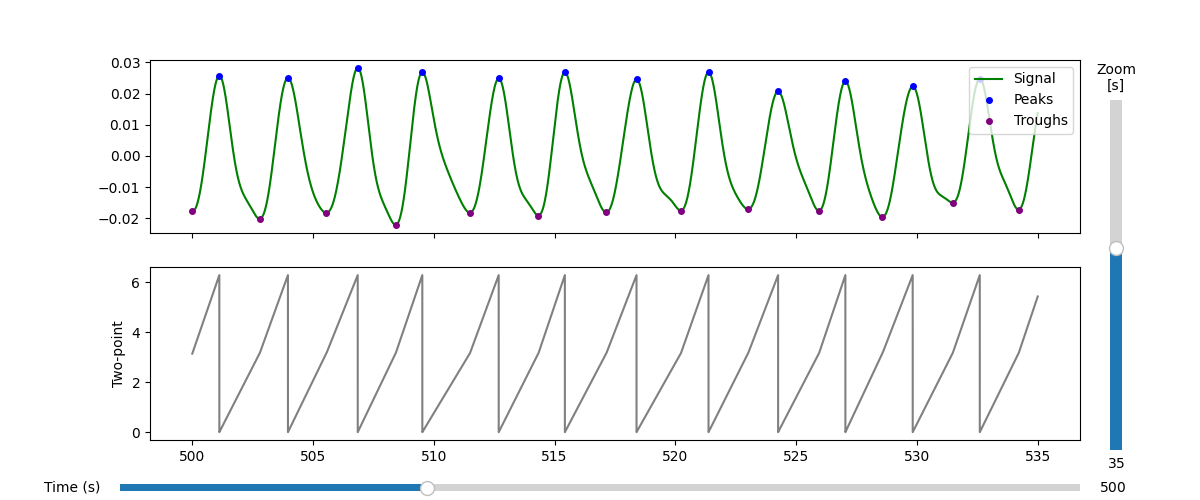

(<Figure size 1200x500 with 4 Axes>,
 array([<Axes: >, <Axes: ylabel='Two-point'>], dtype=object))

In [11]:
%matplotlib widget
plot_phase_diagnostics(
    {"Two-point": phase},
    start = 500,
    window_duration = 35,
    fs = resp_raw.fs,
    data = resp_raw.ts, #the preproccessed data
    peaks=peaks,
    troughs=troughs,
)

## Extracting phase events


In [12]:
trigger_vals = new_events[:, 2]
sample_indices = new_events[:, 0]

label_mapping = {val: key for key, val in event_ids.items()}


event_labels = np.array([label_mapping.get(trig, "unknown") for trig in trigger_vals])


circ = create_phase_events(
    phase_ts=phase,
    events=sample_indices,
    event_labels=event_labels,
    first_samp = raw.first_samp
)

Rejected 0 out of 400 events (0.0%)


## Initial plotting of the respiratory phase angles for the events


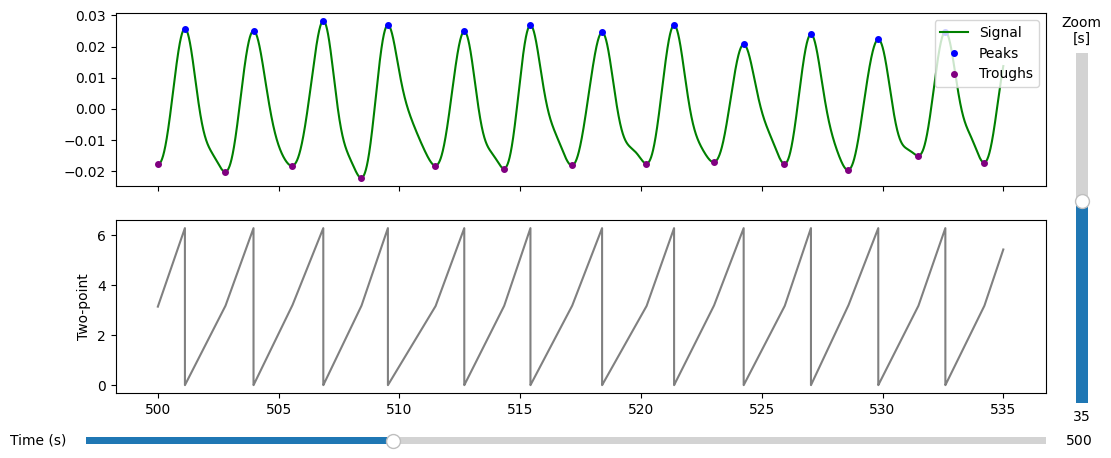

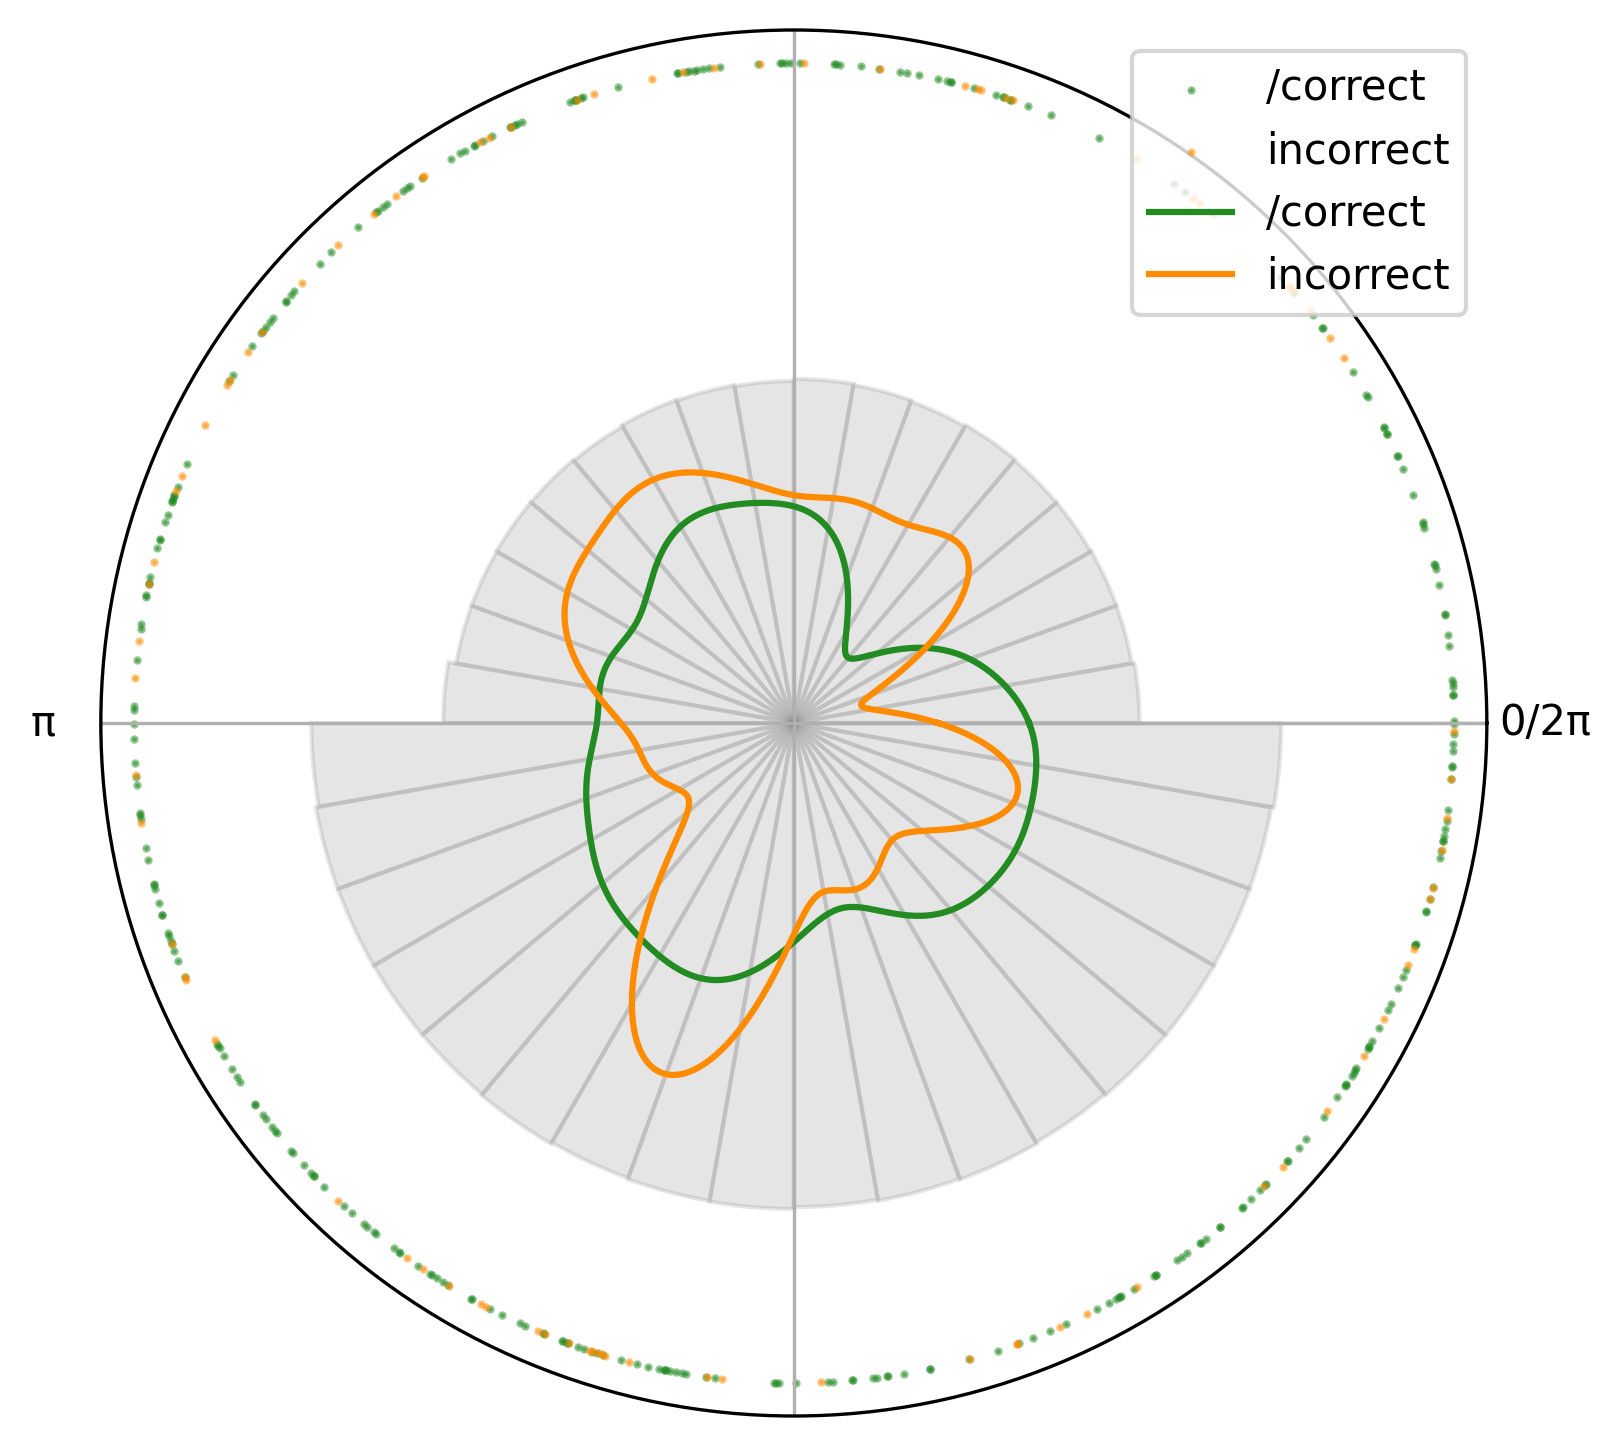

In [13]:
%matplotlib inline

 
plot = CircPlot(circ, group_by_labels=True, colours=["forestgreen", "darkorange"])
plot.add_points(s=1, alpha=0.5)
plot.add_histogram(phase)
plot.add_density()
plot.add_legend()

## Statistical test to see if the distribution of respiratory phase angles differs for correct and incorrect
Permutation test to see if correct and incorrect differs

WRITE ABOUT WATSONS u^2

By default the test statistic .... 

In [14]:
from pyriodic.permutation import permutation_test_between_samples

obs_stat, pval = permutation_test_between_samples(
    circ["/correct"].data,
    circ["incorrect"].data,
    n_permutations=10000
)

Observed statistic = 0.044, p = 0.5556


# How sensitivity differs across the respiratory cycle

In [15]:
import psignifit as ps
import psignifit.psigniplot as psp
import statsmodels.formula.api as smf

First, we will define some parameters for the analysis. 

In [16]:
# PARAMETERS
# for bins refitting of psychometric function
DELTA_CENTER = np.pi/20 # how much are we moving the center of the bin everytime
WIDTH = np.pi/4 # how wide is the bin
N_NULL_LMEM = 10_000 

MIN_TRIALS_PER_BIN = 30 # how many trials would we like as minimum within each bin to include it in the analysis?

Next, we define some helper functions to run the analysis.

In [17]:
def format_data_for_psignifit(intensities, hit_or_miss):
    """
    Formats the data for psignifit by creating a 2D array where each row corresponds to a unique intensity
    and contains the number of hits and total trials for that intensity.

    Args:
        intensities (np.ndarray): Array of stimulus intensities.
        hit_or_miss (np.ndarray): Array of binary responses (1 for hit, 0 for miss).

    Returns:
        np.ndarray: Formatted data array for psignifit.
    """
    unique_intensities = np.unique(intensities)
    formatted_data = np.zeros((len(unique_intensities), 3))

    for i, intensity in enumerate(unique_intensities):
        hits = np.sum((intensities == intensity) & (hit_or_miss == 1))
        misses = np.sum((intensities == intensity) & (hit_or_miss == 0))
        formatted_data[i] = [intensity, hits, hits + misses]

    return formatted_data



def phase_bin_mask(phase_angles, center, width):
    diff = (phase_angles - center + np.pi) % (2*np.pi) - np.pi
    return np.abs(diff) <= width / 2


In [18]:
# empty dataframe to store threshold estimates

PA_correct = circ["/correct"].data
PA_incorrect = circ["incorrect"].data
contrast = df["target_contrast"].round(2) # rounding to fewer decimals to save fitting time

idx_correct = [idx for idx, label in enumerate(circ.labels) if label =="/correct"]
idx_incorrect = [idx for idx, label in enumerate(circ.labels) if label =="incorrect"]

contrast_correct, contrast_incorrect = contrast[idx_correct], contrast[idx_incorrect]

correct_or_incorrect = np.concatenate([
                np.ones(len(PA_correct), dtype=int),
                np.zeros(len(PA_incorrect), dtype=int)
        ])
contrast = np.concatenate([contrast_correct, contrast_incorrect])


PA = np.concatenate([PA_correct, PA_incorrect])


psignifit_kwargs = {
        'experiment_type': '2AFC', 
        'stimulus_range': [np.min(contrast), np.max(contrast)],
    }

result_all_data = ps.psignifit(
        format_data_for_psignifit(contrast, correct_or_incorrect), **psignifit_kwargs
)


/work/LauraBockPaulsen#1941/2025_advanced_cognitive_neuroscience/env/lib/python3.12/site-packages/psignifit/psignifit.py:147: UserWarning: Expects at most 25 blocks in data, got 32.
To save fitting time, consider aggregating blocks of same stimulus level psignifit.pool_blocks(data).
Hide this warning by increasing conf.pool_max_blocks.
  warnings.warn(f"Expects at most {pool_max_blocks} blocks in data, got {len(levels)}.\n"


# Plot the overall fit!

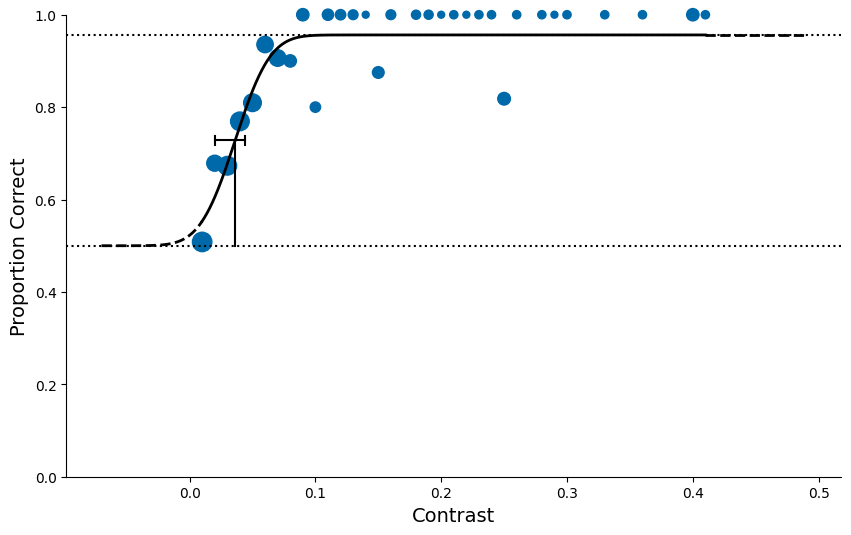

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

psp.plot_psychometric_function(
    result_all_data,
    ax=ax,
    plot_parameter=True,
    x_label="Contrast"
)
ax.set_ylim(0, 1)

plt.show()

# Refitting of the psychometric function using data from different bins of the respiratory cycle

In [20]:
center_of_bins_loop = np.arange(0, 2 * np.pi, DELTA_CENTER)

refitted_results = []
center_of_bins = []
for i, c in enumerate(center_of_bins_loop):
    mask = phase_bin_mask(PA, c, WIDTH)
    tmp_contrast = contrast[mask]        
    tmp_correct_or_incorrect = correct_or_incorrect[mask]

    if len(tmp_correct_or_incorrect) < MIN_TRIALS_PER_BIN:
        print(f"⚠️ Skipping bin at phase {c:.2f} (only {len(tmp_correct_or_incorrect)} trials)")
        continue
    else:
        center_of_bins.append(c)
        

    # All parameters except the threshold were then fixed and used as priors for fitting the psychometric function iteratively to an angle-specific subset of trials (gray functions).
    tmp_result = ps.psignifit(
        format_data_for_psignifit(tmp_contrast, tmp_correct_or_incorrect),
                
        # fixing parameters from fit on full data set
        fixed_parameters = {
            'lambda': result_all_data.parameter_estimate['lambda'],
            'width': result_all_data.parameter_estimate['width']
        },
        **psignifit_kwargs
    )
    refitted_results.append(tmp_result)

thresholds_refitted = [res.parameter_estimate['threshold'] for res in refitted_results]
zscored_thresholds = (thresholds_refitted - np.mean(thresholds_refitted)) / np.std(thresholds_refitted)
        
threshold_estimates_refitting = pd.DataFrame({
    "participant": subject,
    "center": center_of_bins,        
    "sin_phase": np.sin(center_of_bins),
    "cos_phase": np.cos(center_of_bins),
    "threshold": thresholds_refitted,
    "zscored_threshold": zscored_thresholds
})

⚠️ Skipping bin at phase 5.50 (only 29 trials)


# plot the psychometric functions for each phase bin

(<Figure size 1000x600 with 2 Axes>,
 <Axes: xlabel='Contrast', ylabel='Proportion of hits'>)

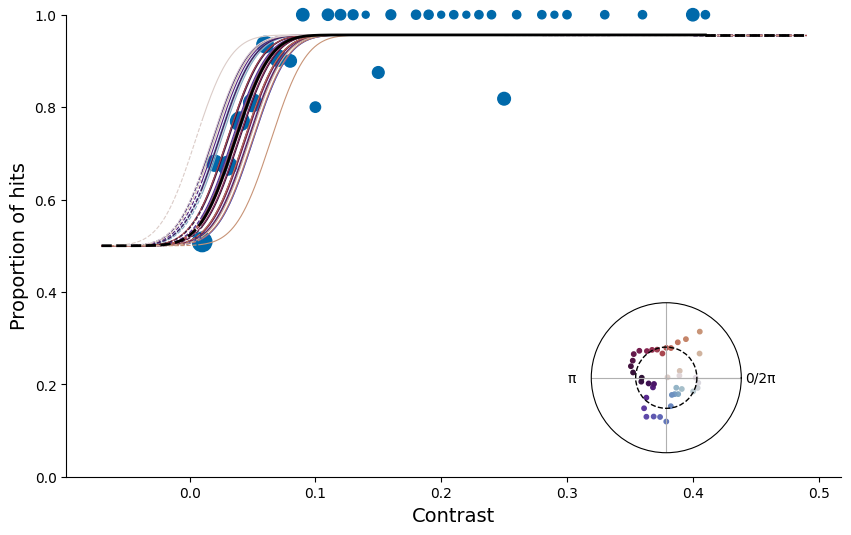

In [21]:

def plot_subject_level(refitted_results, full_fitted_result, center_of_bins):   
    fig, ax = plt.subplots(figsize=(10, 6))

    cmap = plt.cm.twilight
    norm = plt.Normalize(vmin=0, vmax=2*np.pi)

    # Plot psychometric functions color-coded by phase
    for res, c in zip(refitted_results, center_of_bins):
        color = cmap(norm(c))
        psp.plot_psychometric_function(
            res,
            ax=ax,
            line_color=color,
            line_width=0.8,
            plot_parameter=False,
            plot_data=False
        )
   
    # Plot the global fit on top
    psp.plot_psychometric_function(
        full_fitted_result,
        ax=ax,
        line_color="k",
        line_width=2,
        plot_parameter=False,
        plot_data=True,
        x_label="Contrast",
        y_label="Proportion of hits"
    )

    ax.set_ylim((0, 1))

    # ---- ADD POLAR COLOR LEGEND ----

    inset_size = 0.25  # relative size of inset
    inset_margin = 0.15  # margin from edges
    inset_ax = fig.add_axes([1 - inset_margin - inset_size, inset_margin, inset_size, inset_size], projection='polar')
    theta = np.linspace(0, 2*np.pi, 200)
    radii = np.ones_like(theta)


    circ = Circular(center_of_bins) 
    plot = CircPlot(circ=circ, group_by_labels=False, ax=inset_ax)
    

    thresholds = [res.parameter_estimate['threshold'] for res in refitted_results]
    thresholds = np.array(thresholds)

    plot.add_points(
        y = thresholds,
        color = [cmap(norm(c)) for c in center_of_bins],
        s=10
    )

    # add hline at the threshold of the full data fit
    plot.add_hline(full_fitted_result.parameter_estimate['threshold'], c = "k", linestyle='--', linewidth=1,)

    inset_ax.set_ylim(np.min(thresholds)*0.7, np.max(thresholds) * 1.3)
    

    return fig, ax

plot_subject_level(refitted_results, result_all_data, center_of_bins)


<div class="alert alert-block alert-info">
<b>Question:</b> Looking at the above plot, is there anyway you could change the experiment to potentially get better estimates of the threshold in each of the phase bins?
</div>

**Answer:**